<a href="https://colab.research.google.com/github/snghynn/summ/blob/main/ESAA_23_2_project_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split,GridSearchCV
from tqdm import tqdm

from pathlib import Path
import warnings
warnings.filterwarnings(action = 'ignore')

# 1. Data import
## 1) Data Information

In [ ]:
train = pd.read_csv("train.csv")

In [ ]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
train.tail()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0
26456,26456,F,N,N,0,81000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-19569,-1013,1,0,0,0,Security staff,2.0,-9.0,2.0


- gender: 성별
- car: 차량 소유 여부
- reality: 부동산 소유 여부
- child_num: 자녀 수
- income_total: 연간 소득
- income_type: 소득 분류 ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']
- edu_type: 교육 수준 ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']
- family_type: 결혼 여부 ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']
- house_type: 생활 방식  ['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']
- DAYS_BIRTH: 출생일. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미
- DAYS_EMPLOYED: 업무 시작일. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미/ 양수 값은 고용되지 않은 상태를 의미함
- FLAG_MOBIL: 핸드폰 소유 여부
- work_phone: 업무용 전화 소유 여부
- phone: 전화 소유 여부
- email: 이메일 소유 여부
- occyp_type: 직업 유형                                       
- family_size: 가족 규모
- begin_month: 신용카드 발급 월. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미
- credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도 => 낮을 수록 높은 신용의 신용카드 사용자를 의미함

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [ ]:
test = pd.read_csv("test.csv")

In [ ]:
test.tail()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
9995,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0
9996,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0
9997,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0
9998,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0
9999,36456,F,N,Y,0,270000.0,Working,Higher education,Married,House / apartment,-9154,-187,1,0,0,1,Laborers,2.0,-11.0


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          10000 non-null  int64  
 1   gender         10000 non-null  object 
 2   car            10000 non-null  object 
 3   reality        10000 non-null  object 
 4   child_num      10000 non-null  int64  
 5   income_total   10000 non-null  float64
 6   income_type    10000 non-null  object 
 7   edu_type       10000 non-null  object 
 8   family_type    10000 non-null  object 
 9   house_type     10000 non-null  object 
 10  DAYS_BIRTH     10000 non-null  int64  
 11  DAYS_EMPLOYED  10000 non-null  int64  
 12  FLAG_MOBIL     10000 non-null  int64  
 13  work_phone     10000 non-null  int64  
 14  phone          10000 non-null  int64  
 15  email          10000 non-null  int64  
 16  occyp_type     6848 non-null   object 
 17  family_size    10000 non-null  float64
 18  begin_m

In [ ]:
# numeric, category 칼럼 분류
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()

print('numerical feats:\n', numerical_feats)
print('\ncategorical feats:\n', categorical_feats)

numerical feats:
 ['index', 'child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size', 'begin_month']

categorical feats:
 ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']


In [ ]:
# edu type
train['edu_type'].value_counts()

Secondary / secondary special    17995
Higher education                  7162
Incomplete higher                 1020
Lower secondary                    257
Academic degree                     23
Name: edu_type, dtype: int64

In [ ]:
# income type
train['income_type'].value_counts()

Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64

In [ ]:
# family type
train['family_type'].value_counts()

Married                 18196
Single / not married     3496
Civil marriage           2123
Separated                1539
Widow                    1103
Name: family_type, dtype: int64

In [ ]:
# house type
train['house_type'].value_counts()

House / apartment      23653
With parents            1257
Municipal apartment      818
Rented apartment         429
Office apartment         190
Co-op apartment          110
Name: house_type, dtype: int64

## 2) EDA
### (1) gender

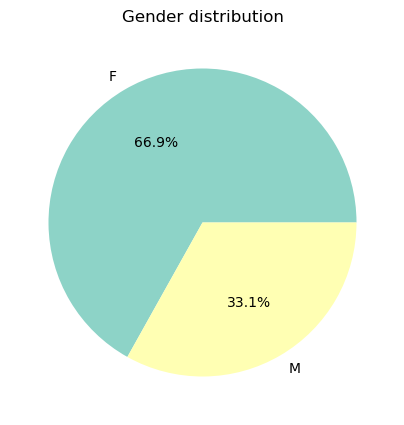

In [ ]:
palette2 = sns.color_palette("Set3", 2)
train_gender = train.groupby('gender').count()['index']
fig = plt.figure(figsize=(5,5))
plt.pie(train_gender, labels = train_gender.index, autopct='%1.1f%%', colors=palette2)
plt.title('Gender distribution')
plt.show()

>- 여성이 남성에 비해 2배가량 많다

### (2) age(DAYS_BIRTH)

In [ ]:
# DAYS_BIRTH를 나이로 변환: 365 나누기
age = round(abs(train['DAYS_BIRTH'])/365.5,0).astype(np.int32)
age.head()

0    38
1    31
2    52
3    41
4    41
Name: DAYS_BIRTH, dtype: int32

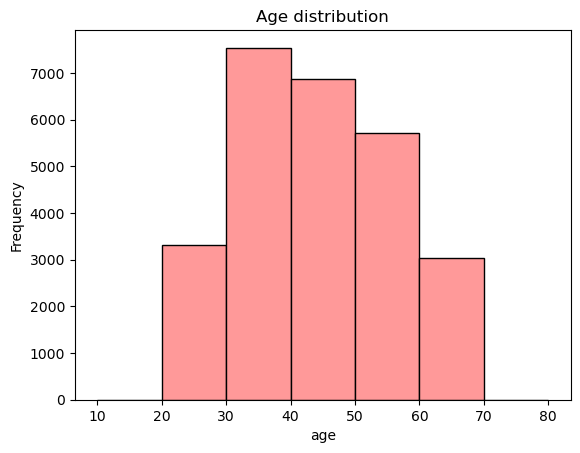

In [ ]:
age.plot.hist(bins=range(10,81,10),color='#ff9999', edgecolor='k')
plt.xlabel('age')
plt.title('Age distribution')
plt.show()

> - 30~50대가 주를 이루고 있다

### (3) car

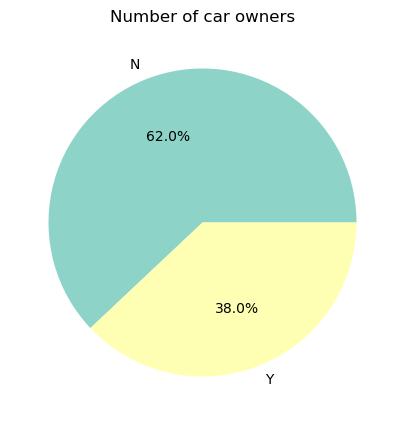

In [ ]:
train_car = train.groupby('car').count()['index']
fig = plt.figure(figsize=(5,5))
plt.pie(train_car, labels=train_car.index, autopct='%1.1f%%', colors=palette2)
plt.title('Number of car owners')
plt.show()

>- 자동차를 소유하지 않는 사람이 더 많다

### (4) 소득분류(income_type)

In [ ]:
train_income = train.groupby('income_type').count()['index']
train_income

income_type
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Working                 13645
Name: index, dtype: int64

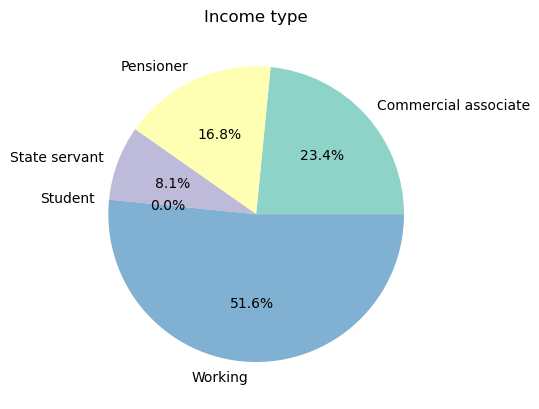

In [ ]:
palette = sns.color_palette("Set3", 5)
plt.pie(train_income, labels=train_income.index, autopct='%1.1f%%', colors=palette)
plt.title('Income type')
plt.show()

### (5) 교육 수준

In [ ]:
train_edu = train.groupby('edu_type').count()['index']
train_edu = train_edu.reset_index()
train_edu

,edu_type,index
0,Academic degree,23
1,Higher education,7162
2,Incomplete higher,1020
3,Lower secondary,257
4,Secondary / secondary special,17995


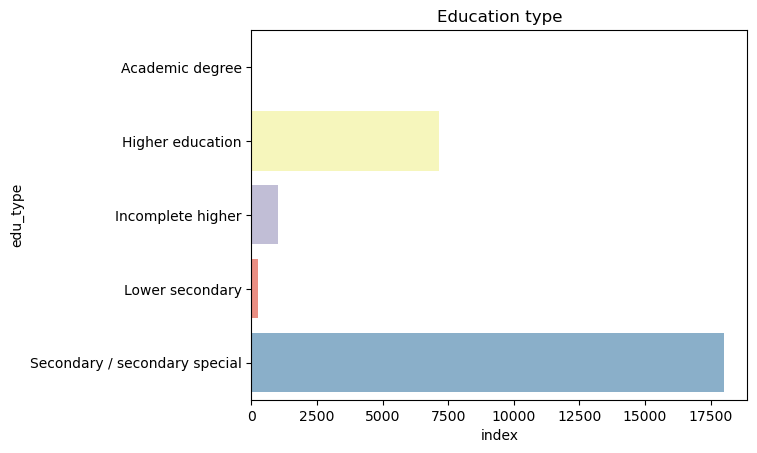

In [ ]:
sns.barplot(data=train_edu, y="edu_type", x="index", orient='h', palette='Set3')
plt.title('Education type')
plt.show()

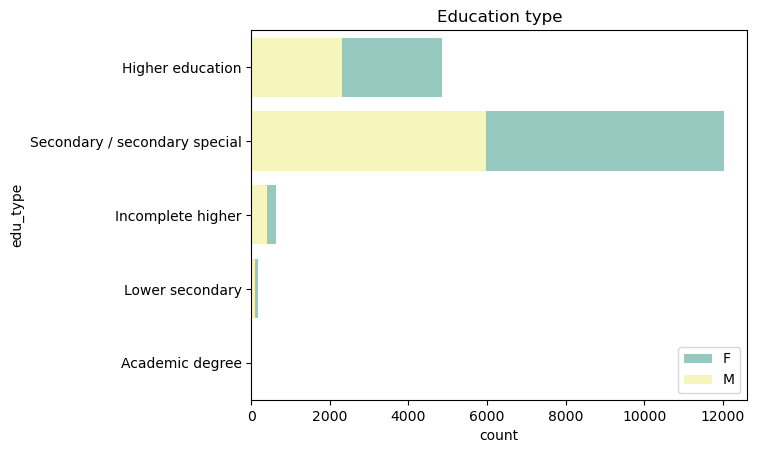

In [ ]:
# gender별 누적합
sns.countplot(data=train, y="edu_type",hue='gender', palette='Set3',dodge=False)
plt.legend(loc='lower right')
plt.title('Education type')
plt.show()

### (6) 결혼 여부

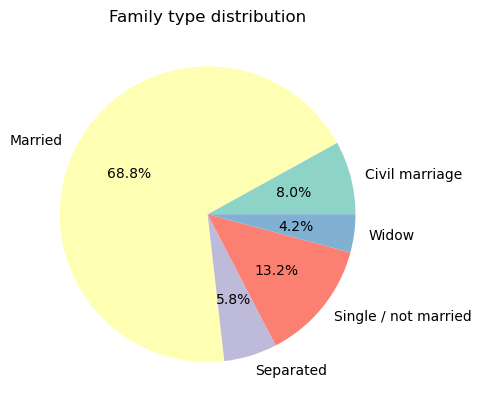

In [ ]:
train_family = train.groupby('family_type').count()['index']
# my_circle=plt.Circle((0,0),0.7,color='white')
fig = plt.figure()
plt.pie(train_family,labels=train_family.index, autopct='%1.1f%%', colors=palette)
p=plt.gcf()
#p.gca().add_artist(my_circle)
plt.title('Family type distribution')
plt.show()

### (7) 연간 소득(income_total)

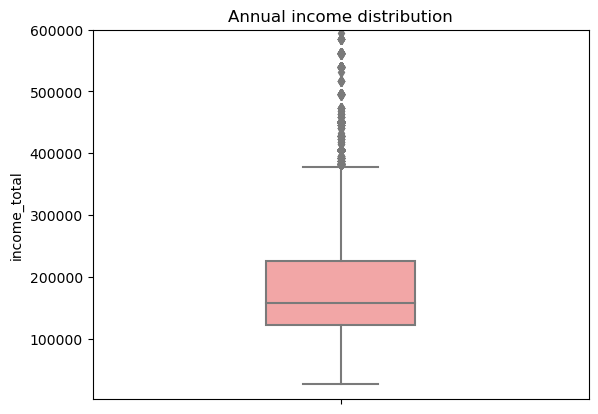

In [ ]:
sns.boxplot(data=train,y="income_total", width=0.3, color='#ff9999')
plt.title('Annual income distribution')
plt.ylim(2000, 600000)
plt.show()

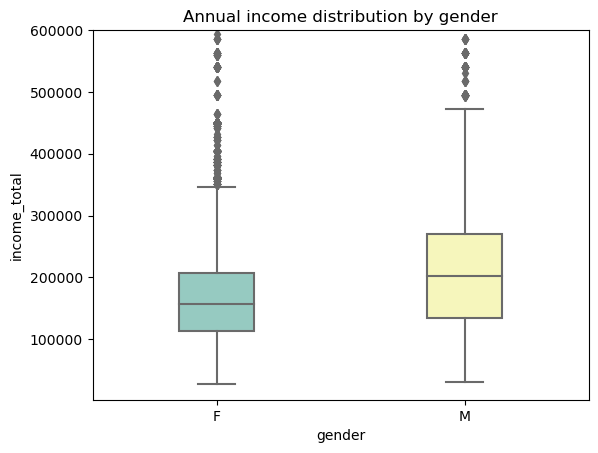

In [ ]:
# gender별 income_total
sns.boxplot(data=train, y="income_total", x='gender', width=0.3, palette='Set3')
plt.title('Annual income distribution by gender')
plt.ylim(2000, 600000)
plt.show()

>- 여성에 비해 남성의 연간소득이 더 많은 편이다.

### (8) 카드 발급월(begin_month)

In [ ]:
train_begin_month = [0 if s >=0 else round(abs(s)/12,2) for s in train['begin_month']]

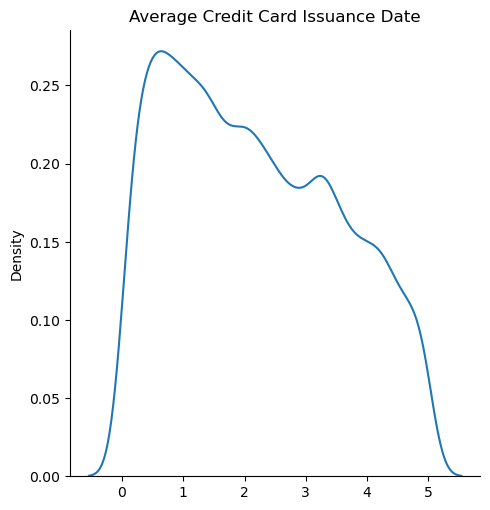

In [ ]:
sns.displot(data=train,x=train_begin_month,kind='kde')
plt.title('Average Credit Card Issuance Date')
plt.show()

### (9) 직업 종류(occyp_type)

In [ ]:
train['occyp_type'].isnull().sum()

8171

[Text(0, 0, 'Accountants'),
 Text(1, 0, 'Cleaning staff'),
 Text(2, 0, 'Cooking staff'),
 Text(3, 0, 'Core staff'),
 Text(4, 0, 'Drivers'),
 Text(5, 0, 'HR staff'),
 Text(6, 0, 'High skill tech staff'),
 Text(7, 0, 'IT staff'),
 Text(8, 0, 'Laborers'),
 Text(9, 0, 'Low-skill Laborers'),
 Text(10, 0, 'Managers'),
 Text(11, 0, 'Medicine staff'),
 Text(12, 0, 'Private service staff'),
 Text(13, 0, 'Realty agents'),
 Text(14, 0, 'Sales staff'),
 Text(15, 0, 'Secretaries'),
 Text(16, 0, 'Security staff'),
 Text(17, 0, 'Waiters/barmen staff')]

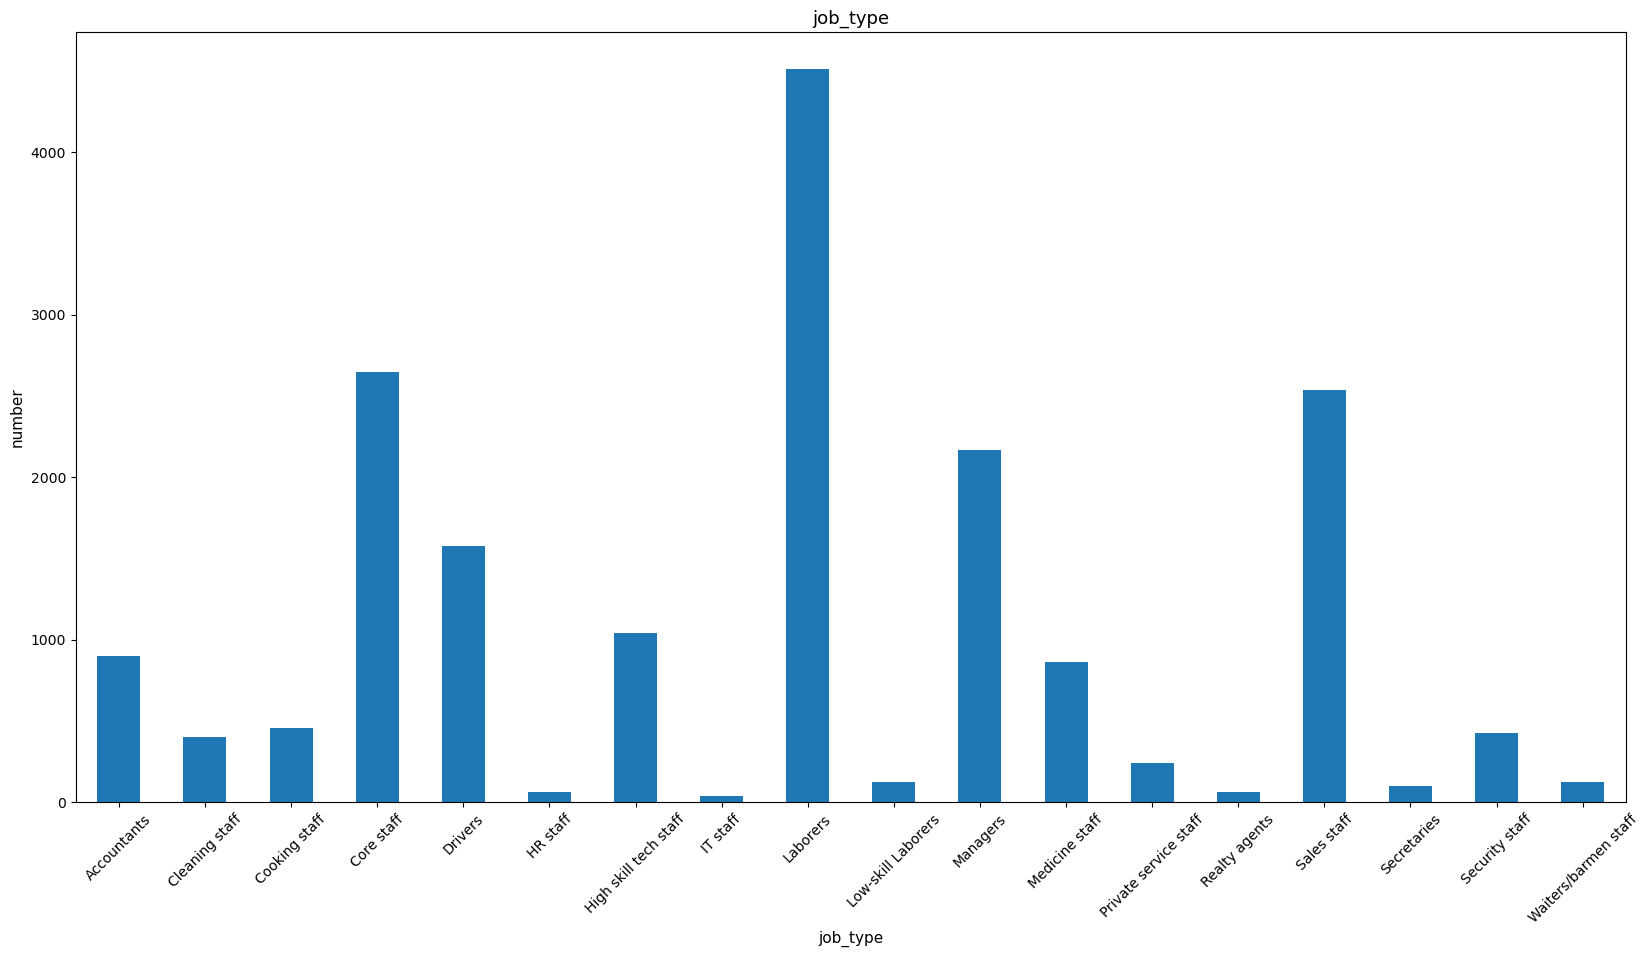

In [ ]:
train_occupation = train.groupby('occyp_type').count()['index']
plot = train_occupation.plot(kind='bar',figsize=(20,10))
plot.set_xlabel('job_type',fontsize=11)
plot.set_ylabel('number',fontsize=11)
plot.set_title('job_type',fontsize=13)
plot.set_xticklabels(labels=train_occupation.index,rotation=45)

>- 직업 종류의 null값이 8171개로 상당히 많이 존재
>- 이를 채울 수 있는 방법? 삭제?

### (10) child_num

<AxesSubplot:>

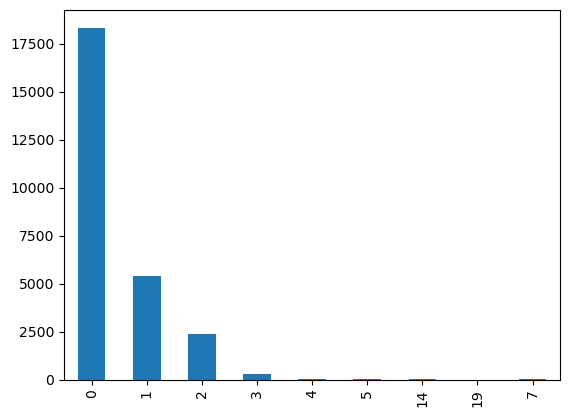

In [ ]:
train['child_num'].value_counts(sort=False).plot.bar()

> - 대부분의 자녀수가 2명 이하임

### (11) income

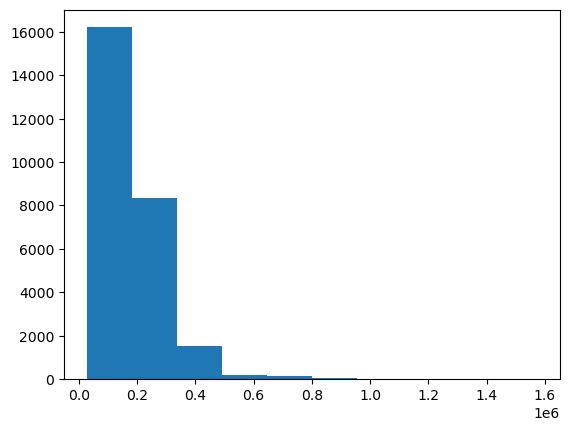

In [ ]:
plt.hist(train['income_total'])
plt.show()

> - skewed to right : 로그 스케일링이 필요해보임

### (10) 신용수준(credit) 데이터

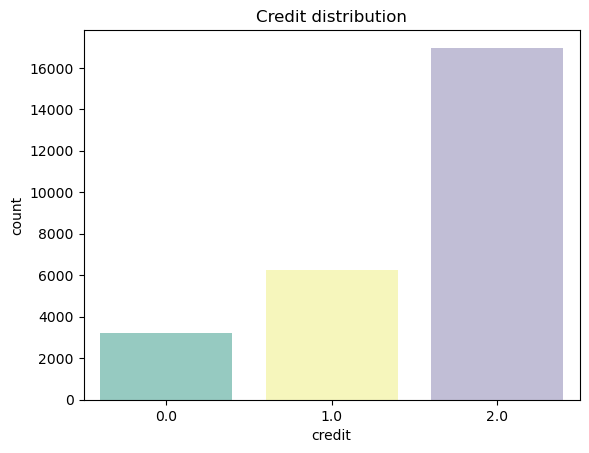

In [ ]:
sns.countplot(data=train, x="credit",palette="Set3")
plt.title('Credit distribution')
plt.show()

> - 신용이 0.0, 1.0, 2.0으로 구성되어 있음(3개의 class)
> - 2.0이 가장 많음

# 2. Data Preprocessing
### 1) Missing values

In [ ]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [ ]:
train=train.drop('occyp_type', axis=1)
test=test.drop('occyp_type', axis=1)

### 2) Label encoding for Binary variables

In [ ]:
# label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['gender'] = le.fit_transform(train['gender'])
test['gender'] = le.fit_transform(test['gender'])

train['car'] = le.fit_transform(train['car'])
test['car'] = le.fit_transform(test['car'])

train['reality'] = le.fit_transform(train['reality'])
test['reality'] = le.fit_transform(test['reality'])

train['phone'] = le.fit_transform(train['phone'])
test['phone'] = le.fit_transform(test['phone'])

train['email'] = le.fit_transform(train['email'])
test['email'] = le.fit_transform(test['email'])

train['work_phone'] = le.fit_transform(train['work_phone'])
test['work_phone'] = le.fit_transform(test['work_phone'])

In [ ]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,2.0,-6.0,1.0
1,1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,3.0,-5.0,1.0
2,2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,2.0,-22.0,2.0
3,3,0,0,1,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,2.0,-37.0,0.0
4,4,0,1,1,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,2.0,-26.0,2.0


> 각각 binary variable의 label encoding이 적절하게 되었다.

### 3) Outlier: child_num
- child_num이 2 이상인 변수들은 child_num = 2로 지정

In [ ]:
train.loc[train['child_num'] >= 2,'child_num']=2
test.loc[test['child_num']>=2, 'child_num']=2

### 4) Continuous variables

#### (1) income

In [ ]:
'''
train['income_total'] = train['income_total'].astype(object)
train['income_total'] = train['income_total']/10000
test['income_total'] = test['income_total']/10000
'''

"\ntrain['income_total'] = train['income_total'].astype(object)\ntrain['income_total'] = train['income_total']/10000 \ntest['income_total'] = test['income_total']/10000\n"

In [ ]:
# income의 data가 치우쳐져 있으므로 log scale 적용
train['income_total'] = np.log1p(1+train['income_total'])

In [ ]:
test['income_total'] = np.log1p(1+test['income_total'])

#### (2) Label Encoding: Type 변수

In [ ]:
print(train['income_type'].unique())
print(train['edu_type'].unique())
print(train['family_type'].unique())
print(train['house_type'].unique())

['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


In [ ]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
train['income_type']=label_encoder.fit_transform(train['income_type'])
test['income_type']=label_encoder.transform(test['income_type'])

train['edu_type']=label_encoder.fit_transform(train['edu_type'])
test['edu_type']=label_encoder.transform(test['edu_type'])

train['family_type']=label_encoder.fit_transform(train['family_type'])
test['family_type']=label_encoder.transform(test['family_type'])

train['house_type']=label_encoder.fit_transform(train['house_type'])
test['house_type']=label_encoder.transform(test['house_type'])

train['income_total']=label_encoder.fit_transform(train['income_total'])
test['income_total']=label_encoder.fit_transform(test['income_total'])

#### (3) Minus continuous variable
- abs 함수 사용

In [ ]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

### 5) 의미없는 변수 제거
- index
- FLAG_MOBIL: 모든 값이 1로 동일

In [ ]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

### 6) Correlation between variables

<AxesSubplot:>

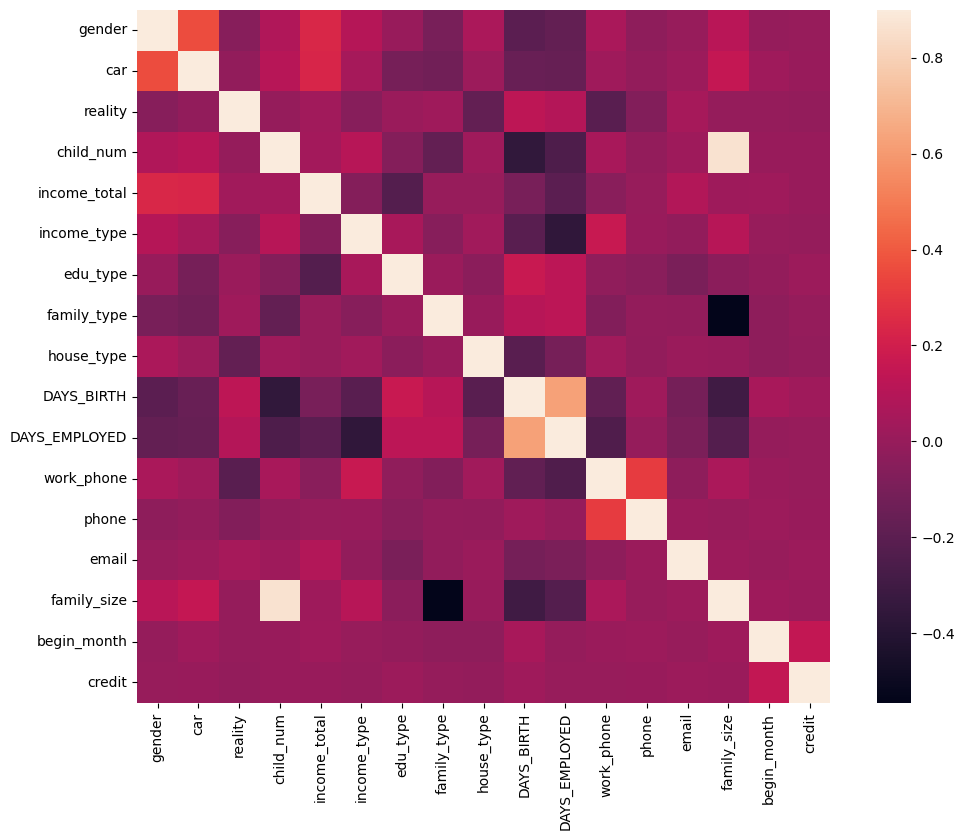

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [ ]:
correlation_matrix = train.corr()

# 상관계수 행렬 출력
print(correlation_matrix)

                 gender       car   reality  child_num  income_total  \
gender         1.000000  0.362320 -0.048927   0.082306      0.236999   
car            0.362320  1.000000 -0.016599   0.105201      0.233500   
reality       -0.048927 -0.016599  1.000000  -0.004181      0.031489   
child_num      0.082306  0.105201 -0.004181   1.000000      0.039099   
income_total   0.236999  0.233500  0.031489   0.039099      1.000000   
income_type    0.103083  0.048361 -0.048468   0.108831     -0.060659   
edu_type       0.006351 -0.105567  0.011535  -0.060029     -0.226699   
family_type   -0.101969 -0.124280  0.028144  -0.175368      0.001247   
house_type     0.067437  0.018617 -0.177957   0.030583     -0.001639   
DAYS_BIRTH    -0.201138 -0.156883  0.130241  -0.357828     -0.101642   
DAYS_EMPLOYED -0.176697 -0.161427  0.098026  -0.245963     -0.202144   
work_phone     0.064316  0.026124 -0.208648   0.054905     -0.046105   
phone         -0.027078 -0.013730 -0.065553  -0.010038     -0.00

In [ ]:
# family_size & child_num이 0.89로 높은 상관계수 -> family_size 제거
train = train.drop('family_size', axis = 1)
test = test.drop('family_size', axis = 1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  int32  
 1   car            26457 non-null  int32  
 2   reality        26457 non-null  int32  
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  int64  
 5   income_type    26457 non-null  int32  
 6   edu_type       26457 non-null  int32  
 7   family_type    26457 non-null  int32  
 8   house_type     26457 non-null  int32  
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  work_phone     26457 non-null  int64  
 12  phone          26457 non-null  int64  
 13  email          26457 non-null  int64  
 14  begin_month    26457 non-null  float64
 15  credit         26457 non-null  float64
dtypes: float64(2), int32(7), int64(7)
memory usage: 2.5 MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         10000 non-null  int32  
 1   car            10000 non-null  int32  
 2   reality        10000 non-null  int32  
 3   child_num      10000 non-null  int64  
 4   income_total   10000 non-null  int64  
 5   income_type    10000 non-null  int32  
 6   edu_type       10000 non-null  int32  
 7   family_type    10000 non-null  int32  
 8   house_type     10000 non-null  int32  
 9   DAYS_BIRTH     10000 non-null  int64  
 10  DAYS_EMPLOYED  10000 non-null  int64  
 11  work_phone     10000 non-null  int64  
 12  phone          10000 non-null  int64  
 13  email          10000 non-null  int64  
 14  begin_month    10000 non-null  float64
dtypes: float64(1), int32(7), int64(7)
memory usage: 898.6 KB


# HGBM

In [ ]:
# Gridsearch
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data,
                       model, param_grid, cv=10, scoring_fit='accuracy',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        n_jobs=8,
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)

    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)
    else:
        pred = fitted_model.predict(X_test_data)

    return fitted_model, pred

In [ ]:
ftr1 = train.drop('credit', axis=1).values
target1 = train['credit'].values
tst_ar1 = test.values
n_class = 3

In [ ]:
# 데이터 분할
X_train,X_val,y_train,y_val=train_test_split(ftr1,target1,test_size=0.25,random_state=40)

In [ ]:
# 모델 객체 생성
model = HistGradientBoostingClassifier()

In [ ]:
# hyperparameter의 grid 정의
paramgrid = {'max_iter' : [1000],
            'learning_rate' : [0.08, 0.09, 0.1, 0.11],
             'max_depth' : [15,17,18,20,22,24,26, 28, 30],
             'max_leaf_nodes' : [26,28,30, 31, 32, 33, 34]
            }
# 모델 학습 및 예측
model, pred = algorithm_pipeline(X_train, X_val, y_train, y_val, model,
                                 paramgrid, cv=10, scoring_fit='accuracy')

Fitting 10 folds for each of 252 candidates, totalling 2520 fits


In [ ]:
# 결과값 출력
print(model.best_score_)
print(model.best_params_)

0.7033564485658569
{'learning_rate': 0.08, 'max_depth': 18, 'max_iter': 1000, 'max_leaf_nodes': 30}


> 최적 파라미터:{'learning_rate': 0.08, 'max_depth': 18, 'max_iter': 1000, 'max_leaf_nodes': 30}

In [ ]:
n_fold = 10 # 데이터 폴드 수 정의

# train, test 데이터의 shape 출력
print(ftr1.shape)
print(tst_ar1.shape)

# StratifiedKFold 교차 검증 객체를 생성
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)

# 예측 결과를 저장할 배열 초기화
hgb_p_val = np.zeros((ftr1.shape[0], n_class))
hgb_p_tst = np.zeros((tst_ar1.shape[0], n_class))

# cv 수행
for i, (i_trn, i_val) in enumerate(cv.split(ftr1, target1), 1):
    print(f'training model for CV #{i}')
    # hgb classifier 모델 초기화
    hgb_clf = HistGradientBoostingClassifier(max_iter=1000,
                                             learning_rate = 0.08,
                                                verbose=True,
                                             max_leaf_nodes = 30,
                                             max_depth = 18,
                                                )
    # train data로 모델 학습
    hgb_clf.fit(ftr1[i_trn], target1[i_trn])
    # test data에 대한 예측 결과 저장
    hgb_p_val[i_val, :] = hgb_clf.predict_proba(ftr1[i_val])
    # test data에 대한 예측 결과를 누적하여 저장
    hgb_p_tst += hgb_clf.predict_proba(tst_ar1) / n_fold

(26457, 15)
(10000, 15)
training model for CV #1
Binning 0.003 GB of training data: 0.053 s
Binning 0.000 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
[1/1000] 3 trees, 90 leaves (30 on avg), max depth = 13, train loss: 0.85953, val loss: 0.86299, in 0.058s
[2/1000] 3 trees, 90 leaves (30 on avg), max depth = 13, train loss: 0.84346, val loss: 0.84944, in 0.060s
[3/1000] 3 trees, 90 leaves (30 on avg), max depth = 13, train loss: 0.83150, val loss: 0.84056, in 0.060s
[4/1000] 3 trees, 90 leaves (30 on avg), max depth = 15, train loss: 0.82172, val loss: 0.83368, in 0.062s
[5/1000] 3 trees, 90 leaves (30 on avg), max depth = 15, train loss: 0.81383, val loss: 0.82842, in 0.059s
[6/1000] 3 trees, 90 leaves (30 on avg), max depth = 11, train loss: 0.80705, val loss: 0.82414, in 0.058s
[7/1000] 3 trees, 90 leaves (30 on avg), max depth = 14, train loss: 0.80141, val loss: 0.82069, in 0.059s
[8/1000] 3 trees, 90 leaves (30 on avg), max depth = 12, train loss: 0.79603, val

In [ ]:
print('logloss: ', f'{log_loss(target1, hgb_p_val)}')
print(confusion_matrix(target1, np.argmax(hgb_p_val, axis=1)))

logloss:  0.7440121564743705
[[  296   421  2505]
 [   86  1977  4204]
 [  124   340 16504]]
